# Modeling

### Our goal is to produce a regression model that outperforms the baseline in predicting the target value -- in this case, the assessed (e.g., not actual) value of a single-unit property.

I will:
 * define the baseline and evaluate it on train and validate data
 * use automated feature selection to choose features for models
 * decide if I want to create any new features based on existing features
 * decide whether to drop features
 * choose which algorithms and hyperparameters I'd like to use first
 * create, fit, and transform models
 * evaluate on validate then tweak hyperparameters if needed
 * evaluate my model(s) on the test data set
 * create a model.py file to make this Modeling reproducible

### To-do list:

 * use automated feature selection to choose features for models
 * decide if I want to create any new features based on existing features
 * decide whether to drop features
 * choose which algorithms and hyperparameters I'd like to use first
 * create, fit, and transform models
 * evaluate on validate then tweak hyperparameters if needed
 * evaluate my model(s) on the test data set
 * create a model.py file to make this Modeling reproducible

## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, TweedieRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

from acquire_kwame import get_zillow_data
from prepare_kwame import prepare_zillow

## Acquire and Prepare Data

In [2]:
df, train, validate, test, X_train, X_validate, X_test, y_train, y_validate, y_test = prepare_zillow()
train.head(3)

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt
55990,10794022,2161904,2.0,2.0,920.0,291160.0
6478,11017636,207554,3.0,4.0,2159.0,429683.0
231,14394667,1369676,3.0,4.0,3309.0,1452674.0


## Summarize Data

In [3]:
y_train.describe()

count    4.333100e+04
mean     4.906478e+05
std      6.688796e+05
min      3.254000e+03
25%      2.068980e+05
50%      3.590730e+05
75%      5.696535e+05
max      4.906124e+07
Name: taxvaluedollarcnt, dtype: float64

(11240.0, 10061240.0)

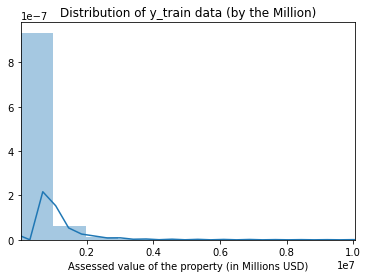

In [4]:
sns.distplot(y_train)
plt.title('Distribution of y_train data (by the Million)')
plt.xlabel('Assessed value of the property (in Millions USD)')
plt.xlim(right=1.006124e+07)
plt.xlim(left=0.001124e+07)

(44011240.0, 49961240.0)

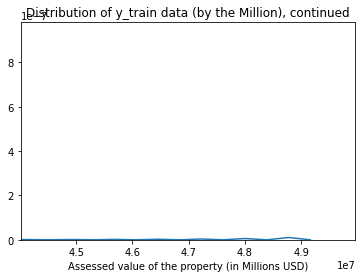

In [5]:
sns.distplot(y_train)
plt.title('Distribution of y_train data (by the Million), continued')
plt.xlabel('Assessed value of the property (in Millions USD)')
plt.xlim(right=4.996124e+07)
plt.xlim(left=4.401124e+07)

The data has a Normal Distribution and is skewed right.

In [6]:
train.bathroomcnt.value_counts()

2.0     17630
3.0      9767
1.0      7229
2.5      3746
4.0      1903
1.5       762
5.0       563
3.5       562
4.5       396
6.0       242
0.0       227
5.5       129
7.0        58
8.0        54
6.5        30
9.0        12
7.5        12
10.0        4
11.0        2
18.0        1
8.5         1
13.0        1
Name: bathroomcnt, dtype: int64

In [7]:
train.columns

Index(['parcelid', 'id', 'bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'taxvaluedollarcnt'],
      dtype='object')

In [8]:
train.calculatedfinishedsquarefeet.value_counts()

1120.0    105
1200.0    101
1440.0     82
1400.0     76
1080.0     72
         ... 
5940.0      1
4475.0      1
4871.0      1
5300.0      1
3884.0      1
Name: calculatedfinishedsquarefeet, Length: 4391, dtype: int64

## Define and Evaluate Baseline

In [9]:
np.mean(y_train)
# np.median(y_train)

490647.81188987097

In [10]:
y_train.shape

(43331,)

I was going to use the median, because I noticed some outliers in the y_train data, but upon evaluating on train and validate, I found that the mean performed better.

In [11]:
baseline = y_train.mean()

baseline_rmse_train = mean_squared_error(y_train, np.full(len(y_train), baseline))**1/2
print('RMSE (Root Mean Square Error) of Baseline on train data:\n', baseline_rmse_train)
baseline_rmse_validate = mean_squared_error(y_validate, np.full(len(y_validate), baseline))**1/2
print('RMSE (Root Mean Square Error) of Baseline on validate data:\n', baseline_rmse_validate)

RMSE (Root Mean Square Error) of Baseline on train data:
 223694795090.09143
RMSE (Root Mean Square Error) of Baseline on validate data:
 180278256025.62784


## Feature Engineering

### Create a New Feature

On next iteration of MVP (time allowing) I will also create a feature that is the ratio of bath+bed count to square footage.

In [12]:
X_train.columns

Index(['parcelid', 'id', 'bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet'],
      dtype='object')

In [13]:
train['bathbedcnt'] = X_train.bathroomcnt + X_train.bedroomcnt
validate['bathbedcnt'] = X_validate.bathroomcnt + X_validate.bedroomcnt
test['bathbedcnt'] = X_test.bathroomcnt + X_test.bedroomcnt

X_train['bathbedcnt'] = X_train.bathroomcnt + X_train.bedroomcnt
X_validate['bathbedcnt'] = X_validate.bathroomcnt + X_validate.bedroomcnt
X_test['bathbedcnt'] = X_test.bathroomcnt + X_test.bedroomcnt

y_train['bathbedcnt'] = X_train.bathroomcnt + X_train.bedroomcnt
y_validate['bathbedcnt'] = X_validate.bathroomcnt + X_validate.bedroomcnt
y_test['bathbedcnt'] = X_test.bathroomcnt + X_test.bedroomcnt

X_train.head()

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,bathbedcnt
55990,10794022,2161904,2.0,2.0,920.0,4.0
6478,11017636,207554,3.0,4.0,2159.0,7.0
231,14394667,1369676,3.0,4.0,3309.0,7.0
8648,10729885,717282,2.0,4.0,1570.0,6.0
32526,14138791,369561,2.0,3.0,1325.0,5.0


### Choose Features - Recursive Feature Elimination: RFE

[ Next step here ]

In [14]:
X_train.columns

Index(['parcelid', 'id', 'bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'bathbedcnt'],
      dtype='object')

In [15]:
# prep data

train, test = train_test_split(df, random_state=123, train_size=.80)

x_cols = ['bathroomcnt', 'bedroomcnt',
       'calculatedfinishedsquarefeet', 'bathbedcnt']

train['bathbedcnt'] = train.bathroomcnt + train.bedroomcnt
test['bathbedcnt'] = test.bathroomcnt + test.bedroomcnt

X_train['bathbedcnt'] = train.bathroomcnt + train.bedroomcnt
X_test['bathbedcnt'] = test.bathroomcnt + test.bedroomcnt

y_train['bathbedcnt'] = train.bathroomcnt + train.bedroomcnt
y_test['bathbedcnt'] = test.bathroomcnt + test.bedroomcnt

X_train_rfe = train[x_cols]
y_train_rfe = train.taxvaluedollarcnt

X_test_rfe = test[x_cols]
y_test_rfe = test.taxvaluedollarcnt

In [16]:
train = train.dropna()
test = train.dropna()

X_train = train.dropna()
X_test = train.dropna()

y_train = train.dropna()
y_test = train.dropna()

y_train_rfe = train.dropna()
y_test_rfe = train.dropna()

X_train.shape

(61902, 7)

In [17]:
k = 2

# create and fit linear regression object
lm = LinearRegression(normalize = True)
lm.fit(X_train_rfe, y_train_rfe)
# create and fit the rfe object
rfe = RFE(lm, k)
rfe.fit(X_train_rfe, y_train_rfe)
X_train_rfe.columns[rfe.support_]

rfe.support_

array([False,  True, False,  True])

In [18]:
print('RFE Selected Features:\n', X_train_rfe.columns[rfe.support_])

RFE Selected Features:
 Index(['bedroomcnt', 'bathbedcnt'], dtype='object')


In [19]:
X_train.head(3)

,parcelid,id,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,bathbedcnt
33409,11158830,2490010,4.0,5.0,3583.0,583569.0,9.0
17578,10766164,896246,2.0,4.0,1748.0,56898.0,6.0
64621,11590590,2360408,2.0,2.0,1397.0,944181.0,4.0


### Based on my RFE results, I will use bedroomcnt and bathbedcnt as our predicter features.

## Make Models, Evaluate Models, and Test Models

### Ordinary Least Squares (OLS) using LinearRegression

1. Fit the model using X_train_scaled and the labels from y_train.
2. Predict final grade for students in training sample using our model (lm).
3. Evaluate using RMSE
4. Repeat predictions and evaluation for validation.
5. Compare RMSE train vs. validation. Overfitting?

In [24]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data.
lm.fit(X_train, y_train.taxvaluedollarcnt)

# predict train
y_train['taxvaluedollarcnt_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxvaluedollarcnt_pred_lm)**1/2

# predict validate
y_test['taxvaluedollarcnt_pred_lm'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.taxvaluedollarcnt, y_test.taxvaluedollarcnt_pred_lm)**1/2

print("RMSE for OLS using LinearRegression on train data:\n", rmse_train, '\n\n', 
      "On test data:\n", rmse_test)

RMSE for OLS using LinearRegression on train data:
 5.588181888996218e-19 

 On test data:
 5.588181888996218e-19


### Second Model

### Third Model

## Create Model.py file

See project repo for the file.

[ Done with Model MVP when you reach here ]